In [178]:
!pip install sklearn-crfsuite
!pip install pythainlp

In [179]:
from google.colab import files
uploaded = files.upload()

In [180]:
import codecs
import pickle
from pythainlp.tokenize import word_tokenize
from pythainlp.tag import pos_tag
from pythainlp.tokenize import Tokenizer
from pythainlp.util.trie import Trie, dict_trie
from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords
from nltk.tokenize import RegexpTokenizer
import glob
import nltk
import scipy.stats
import re
from sklearn_crfsuite import scorers,metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate,train_test_split
import sklearn_crfsuite
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [181]:
file_name="30_data_ok_" # ชื่อไฟล์คลังข้อมูล
def get_data(fileopen):
	"""
    สำหรับใช้อ่านทั้งหมดทั้งในไฟล์ทีละรรทัดออกมาเป็น list
    """
	with codecs.open(fileopen, 'r',encoding='utf-8-sig') as f:
		lines = f.read().splitlines()
	return [a for a in lines if Unique(a)]# เอาไม่ซ้ำกัน

<h1># จัดการกับ tag ที่ไม่ได้ tag

In [182]:
def toolner_to_tag(text):
 text=text.strip()
 text=text.replace(" ","")
 text=re.sub("<[^>]*>","",text)
 text=re.sub("(\[\/(.*?)\])","\\1***",text)#.replace('(\[(.*?)\])','***\\1')#  ตัดการกับพวกไม่มี tag word
 text=re.sub("(\[\w+\])","***\\1",text)
 text2=[]
 for i in text.split('***'):
  if "[" in i:
   text2.append(i)
  else:
   text2.append("[word]"+i+"[/word]")
 text="".join(text2)#re.sub("[word][/word]","","".join(text2))
 return text.replace("[word][/word]","")

In [183]:
#text2conll2002("ดังนั้น[noun]คำสั่งฟ้อง[/noun][Noun Conjunctions]ของ[/Noun Conjunctions][noun]อธิบดี[/noun][noun]อัยการ[/noun][noun]สำนักงานคดีอาญา[/noun][noun]กรุงเทพใต้[/noun][word before verb]จึง[/word before verb][word before verb]ยังคงใช้[/word before verb][intransitive verb]บังคับ[/intransitive verb][word after verb]อยู่[/word after verb][Adverbs]เช่นเดิม[/Adverbs]แต่[Noun phrase]การที่รองอัยการสูงสุด[/Noun phrase]")

In [184]:
def text2conll2002(text,pos=True):
    """
    ใช้แปลงข้อความให้กลายเป็น conll2002
    """
    text=toolner_to_tag(text) # นำไปใส่ tag [word] "[word]เราจะไปเดินเล่นที่[/word]"
    text=text.replace("''",'"')
    text=text.replace("’",'"').replace("‘",'"')#.replace('"',"")
    tag=tokenizer.tokenize(text) # แยก tag ออกมาจากข้อความ [('word', 'ฉันจะไปเดินเล่นที่', 'word'),('LOCATION', 'หนองคาย', 'LOCATION'),('word', 'พร้อมกับนั่งเรือข้ามไป', 'word'),('LOCATION', 'ประเทศลาว', 'LOCATION')]
    j=0
    conll2002="" # ประกาศตัวแปรเก็บ conll2002
    for tagopen,text,tagclose in tag: # ลูปใน tag โดยเป็น (tagopen,text,tagclose) word_tokenize(text,engine="newmm")
        word_cut=_tokenizer.word_tokenize(text) # ใช้ตัวตัดคำ newmm ของ PyThaiNLP ['ฉัน', 'จะ', 'ไป', 'เดินเล่น', 'ที่']['หนองคาย']['พร้อมกับ', 'นั่ง', 'เรือ', 'ข้าม', 'ไป']['ประเทศ', 'ลาว']
        i=0
        txt5=""
        while i<len(word_cut): #ลูปตามจำนวน token ที่ตัดในtag
            if word_cut[i]=="''" or word_cut[i]=='"':pass
            elif i==0 and tagopen!='word': # ไม่เป็น tag [word] และเป็น i หรือตัวเริ่มต้น tag
                txt5+=word_cut[i]
                txt5+='\t'+''+tagopen
            elif tagopen!='word':
                txt5+=word_cut[i]
                txt5+='\t'+''+tagopen
            else: # เป็น [word]
                txt5+=word_cut[i]
                txt5+='\t'+'O'
            txt5+='\n'
            #j+=1
            i+=1
        conll2002+=txt5
    if pos==False:
        return conll2002
    return postag(conll2002)

In [185]:
def postag(text):
    listtxt=[i for i in text.split('\n') if i!='']
    list_word=[]
    for data in listtxt:
        list_word.append(data.split('\t')[0])
    #print(text)
    list_word=pos_tag(list_word,engine="perceptron")
    text=""
    i=0
    for data in listtxt:
        text+=data.split('\t')[0]+'\t'+list_word[i][1]+'\t'+data.split('\t')[1]+'\n'
        i+=1
    return text

In [186]:
def alldata(lists):
    text=""
    for data in lists:
        text+=text2conll2002(data)
        text+='\n'
    return text

In [187]:
def alldata_list(lists):
    data_all=[] 
    print(lists)
    for data in lists:
        data_num=[]
        try:
            txt=text2conll2002(data,pos=True).split('\n') # นำไปแปลงเป็น conll2002
            
            for d in txt:
                tt=d.split('\t')
                if d!="":
                    if len(tt)==3:
                        data_num.append((tt[0],tt[1],tt[2]))
                    else:
                        data_num.append((tt[0],tt[1]))
            #print(data_num)
            data_all.append(data_num)
        except:
            print(data)
    #print(data_all)
    return data_all

In [188]:
def alldata_list_str(lists):
	string=""
	for data in lists:
		string1=""
		for j in data:
			string1+=j[0]+"	"+j[1]+"	"+j[2]+"\n"
		string1+="\n"
		string+=string1
	return string

In [189]:
def get_data_tag(listd):
	list_all=[]
	c=[]
	for i in listd:
		if i !='':
			c.append((i.split("\t")[0],i.split("\t")[1],i.split("\t")[2]))
		else:
			list_all.append(c)
			c=[]
	return list_all

In [190]:
def getall(lista):
    ll=[]  
    print(lista)
    for i in lista:
        o=True
        for j in ll:
            if re.sub("\[(.*?)\]","",i)==re.sub("\[(.*?)\]","",j):
                o=False
                break
        if o==True:
            ll.append(i)
            #print(i)
    return ll

In [191]:
def urlify(s):
    s = re.sub(r"\s+", '', s)
    return s

In [192]:
def get_ner(text):
    #_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')
    #_tokenizer.word_tokenize(text)
    fillter = []
    cut=urlify(text)
    word_cut=_tokenizer.word_tokenize(cut)
    stopwords = set("")
    stopwords.add("(")
    stopwords.add(")")
    for w in word_cut:
      if w not in stopwords:
        fillter.append(w)
    list_word=pos_tag(fillter,engine='perceptron')
    X_test = extract_features([(data,list_word[i][1]) for i,data in enumerate(fillter)])
    y_=crf.predict_single(X_test)
    d.append([(fillter[i],data) for i,data in enumerate(y_)])
    #[(word_cut[i],list_word[i][1],data) for i,data in enumerate(y_)]
    #print(d)
    return True,y_


In [193]:
def doc2features(doc, i):
    word = doc[i][0]
    postag = doc[i][1]
    # Features from current word
    features={
        'word.word': word,
        'word.isspace':word.isspace(),
        'postag':postag,
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        prevword = doc[i-1][0]
        postag1 = doc[i-1][1]
        features['word.prevword'] = prevword
        features['word.previsspace']=prevword.isspace()
        features['word.prepostag'] = postag1
        features['word.prevwordisdigit'] = prevword.isdigit()
    else:
        features['BOS'] = True # Special "Beginning of Sequence" tag
    # Features from next word
    if i < len(doc)-1:
        nextword = doc[i+1][0]
        postag1 = doc[i+1][1]
        features['word.nextword'] = nextword
        features['word.nextisspace']=nextword.isspace()
        features['word.nextpostag'] = postag1
        features['word.nextwordisdigit'] = nextword.isdigit()
    else:
        features['EOS'] = True # Special "End of Sequence" tag
    return features

In [194]:
def extract_features(doc):
    return [doc2features(doc, i) for i in range(len(doc))]

def get_labels(doc):
    return [tag for (token,postag,tag) in doc]

<h1>จัดการประโยคซ้ำ

In [195]:
data_not=[]
def Unique(p):
 text=re.sub("<[^>]*>","",p)
 text=re.sub("\[(.*?)\]","",text)
 text=re.sub("\[\/(.*?)\]","",text)   
 if text not in data_not:
  data_not.append(text)
  return True
 else:
  return False

<h1># เตรียมตัวตัด tag ด้วย re

In [196]:
pattern = r'\[(.*?)\](.*?)\[\/(.*?)\]'
tokenizer = RegexpTokenizer(pattern) # ใช้ nltk.tokenize.RegexpTokenizer เพื่อตัด [TIME]8.00[/TIME] ให้เป็น ('TIME','ไง','TIME')

In [197]:
custom_words_list = set(thai_words())
custom_words_list.add('การที่รองอัยการสูงสุด')
custom_words_list.add('ผบ.ตร.')
custom_words_list.add('คำสั่งฟ้อง')
trie = dict_trie(dict_source=custom_words_list)
_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')

In [198]:
data_not=[]
data1=getall(get_data(file_name+".txt")) # นำคลังเข้าไป แยกออกเป็น list ละบรรทัด
datatofile=alldata_list(data1) # นำไปผ่านขั้นตอน 1 2 3 4
tt=[]
with open(file_name+"-pos.conll","w") as f:
    i=0
    while i<len(datatofile):
        for j in datatofile[i]:
            f.write(j[0]+"\t"+j[1]+"\t"+j[2]+"\n")
        if i+1<len(datatofile):
            f.write("\n")
        i+=1

with open(file_name+".conll","w") as f:
    i=0
    while i<len(datatofile):
        for j in datatofile[i]:
            f.write(j[0]+"\t"+j[2]+"\n")
        if i+1<len(datatofile):
            f.write("\n")
        i+=1

['[Prepositions]แต่[/Prepositions][noun]สิ่ง[/noun][SS Conjunctions]ที่[/SS Conjunctions] [intransitive verb] ชี้[/intransitive verb] [word before verb]ให้[/word before verb][transitive verb]เห็น[/transitive verb][SS Conjunctions]ว่า[/SS Conjunctions] [Negator]มิ[/Negator][word before verb]ได้[/word before verb] [transitive verb]เป็น[/transitive verb][word after verb]ไป[/word after verb] [Prepositions]ตาม[/Prepositions] [noun]ครรลอง[/noun][noun]ระบอบ[/noun][noun]ประชาธิปไตย[/noun] [Noun Conjunctions]และ[/Noun Conjunctions][noun]กระบวนการ[/noun][noun]รัฐธรรมนูญ[/noun][word before verb]ก็[/word before verb][transitive verb]คือ[/transitive verb] [Time expression word]เมื่อ[/Time expression word][Time expression word]ก่อน[/Time expression word] [noun]การชุมนุม[/noun][Noun Conjunctions]ของ[/Noun Conjunctions][noun]บุคคล[/noun][Pronouns]ใด[/Pronouns][Adverbs]ก็ตาม[/Adverbs][word before verb]ก็[/word before verb][word before verb]จะ[/word before verb] [transitive verb]อ้าง[/transitive verb][P

In [199]:
datatofile[0]

[('แต่', 'JCRG', 'Prepositions'),
 ('สิ่ง', 'NCMN', 'noun'),
 ('ที่', 'PREL', 'SSConjunctions'),
 ('ชี้', 'VACT', 'intransitiveverb'),
 ('ให้', 'JSBR', 'wordbeforeverb'),
 ('เห็น', 'VSTA', 'transitiveverb'),
 ('ว่า', 'JSBR', 'SSConjunctions'),
 ('มิ', 'NEG', 'Negator'),
 ('ได้', 'XVAM', 'wordbeforeverb'),
 ('เป็น', 'VSTA', 'transitiveverb'),
 ('ไป', 'XVAE', 'wordafterverb'),
 ('ตาม', 'RPRE', 'Prepositions'),
 ('ครรลอง', 'NCMN', 'noun'),
 ('ระบอบ', 'NCMN', 'noun'),
 ('ประชาธิปไตย', 'NCMN', 'noun'),
 ('และ', 'JCRG', 'NounConjunctions'),
 ('กระบวนการ', 'NCMN', 'noun'),
 ('รัฐธรรมนูญ', 'NCMN', 'noun'),
 ('ก็', 'JSBR', 'wordbeforeverb'),
 ('คือ', 'VSTA', 'transitiveverb'),
 ('เมื่อ', 'JSBR', 'Timeexpressionword'),
 ('ก่อน', 'RPRE', 'Timeexpressionword'),
 ('การ', 'FIXN', 'noun'),
 ('ชุมนุม', 'VACT', 'noun'),
 ('ของ', 'RPRE', 'NounConjunctions'),
 ('บุคคล', 'NCMN', 'noun'),
 ('ใด', 'DIAC', 'Pronouns'),
 ('ก็ตาม', 'JCRG', 'Adverbs'),
 ('ก็', 'JSBR', 'wordbeforeverb'),
 ('จะ', 'XVBM', 'wordbef

In [200]:
X_data = [extract_features(doc) for doc in datatofile] # เอา คำ แยกออกมา
y_data = [get_labels(doc) for doc in datatofile] # เอา tag แยกออกมา
X_data[0]

[{'BOS': True,
  'postag': 'JCRG',
  'word.isdigit()': False,
  'word.isspace': False,
  'word.nextisspace': False,
  'word.nextpostag': 'NCMN',
  'word.nextword': 'สิ่ง',
  'word.nextwordisdigit': False,
  'word.word': 'แต่'},
 {'postag': 'NCMN',
  'word.isdigit()': False,
  'word.isspace': False,
  'word.nextisspace': False,
  'word.nextpostag': 'PREL',
  'word.nextword': 'ที่',
  'word.nextwordisdigit': False,
  'word.prepostag': 'JCRG',
  'word.previsspace': False,
  'word.prevword': 'แต่',
  'word.prevwordisdigit': False,
  'word.word': 'สิ่ง'},
 {'postag': 'PREL',
  'word.isdigit()': False,
  'word.isspace': False,
  'word.nextisspace': False,
  'word.nextpostag': 'VACT',
  'word.nextword': 'ชี้',
  'word.nextwordisdigit': False,
  'word.prepostag': 'NCMN',
  'word.previsspace': False,
  'word.prevword': 'สิ่ง',
  'word.prevwordisdigit': False,
  'word.word': 'ที่'},
 {'postag': 'VACT',
  'word.isdigit()': False,
  'word.isspace': False,
  'word.nextisspace': False,
  'word.nextp

In [201]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    model_filename=file_name+"-pos.model1"
)
crf.fit(X_data, y_data)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [202]:
X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1) # แบ่ง 0.1 หรือ 10%
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
    model_filename=file_name+"-pos.model1" # ตั้งชื่อโมเดล
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
labels = list(crf.classes_)
labels.remove('O')
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_data, y_data)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['Prepositions', 'noun', 'SSConjunctions', 'intransitiveverb', 'wordbeforeverb', 'transitiveverb', 'Negator', 'wordafterverb', 'NounConjunctions', 'Timeexpressionword', 'Pronouns', 'Adverbs', 'Numeralword', 'PhrasalVerbs', 'Nounphras

In [203]:
y_pred = crf.predict(X_test)
e=metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)
print(e) # โชว์ประสิทธิภาพ

0.9816774003771159


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [204]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                    precision    recall  f1-score   support

    SSConjunctions      0.960     0.923     0.941        26
      abbreviation      0.800     1.000     0.889         4
        Adjectives      0.000     0.000     0.000         0
           Adverbs      1.000     0.875     0.933        24
           Negator      1.000     1.000     1.000        10
      Sequenceword      0.000     0.000     0.000         0
      PhrasalVerbs      0.923     1.000     0.960        36
Timeexpressionword      1.000     1.000     1.000        20
  intransitiveverb      1.000     1.000     1.000        14
  wordafternumeral      0.000     0.000     0.000         0
     wordafterverb      1.000     0.889     0.941        18
    wordbeforenoun      1.000     1.000     1.000         3
 wordbeforenumeral      1.000     1.000     1.000         5
    wordbeforeverb      0.973     0.973     0.973        37
              noun      0.995     1.000     0.997       198
  NounConjunctions      0.923     1.000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [205]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.36959824173755573, 'c2': 0.0005105265488996227}
best CV score: 0.6229108583693228
model size: 0.17M


In [206]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

Dark blue => 0.5865, dark red => 0.6229


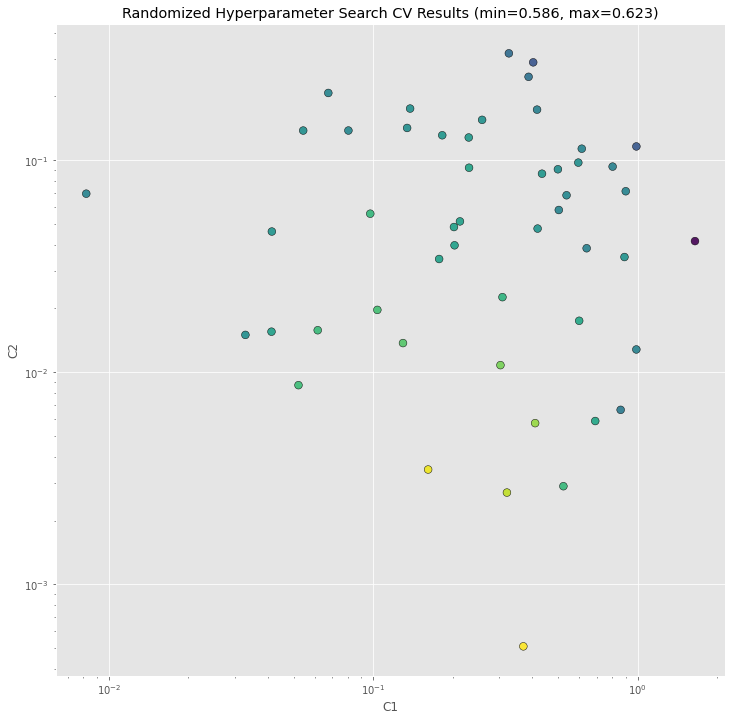

In [207]:
fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".
format(
min(_c), max(_c)
))
ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])
print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [208]:
from collections import Counter
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])        

Top likely transitions:
Nounphrase -> Nounphrase 4.143566
PhrasalVerbs -> PhrasalVerbs 3.715780
Numeralword -> Qualitativenoun 3.358721
Timeexpressionword -> Timeexpressionword 2.899868
Prepositions -> Prepositions 2.589105
noun   -> noun    2.505588
wordbeforeverb -> intransitiveverb 2.486008
Pronouns -> Adjectives 2.411666
wordafterverb -> wordafterverb 2.385765
wordbeforenoun -> noun    2.382828
O      -> O       2.316242
Adverbs -> O       2.256832
Adverbs -> Adverbs 2.225811
NounConjunctions -> NounConjunctions 2.223469
abbreviation -> noun    2.211074
wordbeforenumeral -> Numeralword 2.109505
wordbeforeverb -> transitiveverb 2.092131
transitiveverb -> noun    2.023808
Numeralword -> abbreviation 1.878888
intransitiveverb -> wordafterverb 1.836033

Top unlikely transitions:
Negator -> noun    -1.004719
wordbeforeverb -> Adverbs -1.064025
Nounphrase -> wordbeforeverb -1.069797
Nounphrase -> O       -1.083660
transitiveverb -> Timeexpressionword -1.123340
Nounphrase -> wordafterverb

In [209]:
d = []
while True:
    t=input("Text : ")    
    print(get_ner(t))

Text : เรียน ผู้บังคับบัญชา    ตาม สั่งการของ ผบช.ปส. มอบหมาย กก.ปพ.บช.ปส. และ  บก.ขส.ตรวจสอบข้อมูล บุคคลที่ติดต่อขอเยี่ยมผู้ต้องหา และเก็บเป็นข้อมูลในการสืบสวนขยายผล ต่อไปนั้น     วันนี้(29 พ.ค.63) ร.ต.อ.เสนีย์ มั่นใหญ่ ร้อยเวร กก.ปพ.ฯ ได้ดำเนินการตรวจสอบข้อมูลบุคคลผู้เข้ามาเยี่ยมผู้ต้องหา ห้วงเวลา 09.00-10.00 น. สรุปผลการตรวจสอบได้ ดังนี้ 1. ในช่วงเวลาดังกล่าว มีผู้ต้องหาอยู่ในความควบคุม เป็นชาย 11 ราย หญิง 1 ราย 2. ในช่วงเวลาดังกล่าว พบว่ามีการขอเข้าเยี่ยมผู้ต้องหา 5 ราย แจ้ง บก.ขส. ตรวจสอบทั้งหมดแล้ว ไม่มีประวัติหรือหมายจับ แต่อย่างใด 3. ทั้งนี้ได้ดำเนินการแจ้งให้ บก.ขส.ทราบทางไลน์ไว้เบื้องต้นแล้ว และจะได้ดำเนินการจัดทำบันทึกไว้เป็นหลักฐานมอบให้กับ บก.ขส.บช.ปส.ต่อไป    จึงเรียนมาเพื่อโปรดทราบ
(True, ['transitiveverb', 'noun', 'Prepositions', 'noun', 'NounConjunctions', 'noun', 'noun', 'wordbeforeverb', 'transitiveverb', 'noun', 'noun', 'noun', 'noun', 'NounConjunctions', 'noun', 'noun', 'transitiveverb', 'Nounphrase', 'Nounphrase', 'SSConjunctions', 'PhrasalVerbs', 'PhrasalVerbs', 

KeyboardInterrupt: ignored

In [210]:
d[0]

[('เรียน', 'transitiveverb'),
 ('ผู้บังคับบัญชา', 'noun'),
 ('ตาม', 'Prepositions'),
 ('สั่งการ', 'noun'),
 ('ของ', 'NounConjunctions'),
 ('ผบ', 'noun'),
 ('ช.', 'noun'),
 ('ปส.', 'wordbeforeverb'),
 ('มอบหมาย', 'transitiveverb'),
 ('กก.', 'noun'),
 ('ปพ.', 'noun'),
 ('บช.', 'noun'),
 ('ปส.', 'noun'),
 ('และ', 'NounConjunctions'),
 ('บก', 'noun'),
 ('.ขส.', 'noun'),
 ('ตรวจสอบ', 'transitiveverb'),
 ('ข้อมูล', 'Nounphrase'),
 ('บุคคล', 'Nounphrase'),
 ('ที่', 'SSConjunctions'),
 ('ติดต่อ', 'PhrasalVerbs'),
 ('ขอ', 'PhrasalVerbs'),
 ('เยี่ยม', 'PhrasalVerbs'),
 ('ผู้ต้องหา', 'noun'),
 ('และ', 'NounConjunctions'),
 ('เก็บ', 'transitiveverb'),
 ('เป็น', 'transitiveverb'),
 ('ข้อมูล', 'noun'),
 ('ใน', 'Prepositions'),
 ('การสืบสวน', 'noun'),
 ('ขยายผล', 'noun'),
 ('ต่อไป', 'Adverbs'),
 ('นั้น', 'O'),
 ('วันนี้', 'O'),
 ('29', 'Numeralword'),
 ('พ.ค.', 'abbreviation'),
 ('63', 'Numeralword'),
 ('ร.ต.อ.', 'abbreviation'),
 ('เสนีย์', 'noun'),
 ('มั่น', 'noun'),
 ('ใหญ่', 'noun'),
 ('ร้อยเวร',

In [211]:
with open('model.pkl','wb') as f:
    pickle.dump(crf,f)

In [212]:
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [213]:
text = "วันนี้(วันที่ 5 สิงหาคม 2563) พล.ต.อ.วิสนุ ปราสาททองโอสถ ผู้ช่วย ผบ.ตร.พร้อมด้วย พล.ต.ท.ชินภัทร สารสิน ผบช.ปส.,พล.ต.ต.พรชัย. เจริญวงศ์ รอง ผบช.ปส.พล.ต.ต.วัชระ ทิพย์มงคล ผบก.ปส.3 บช.ปส.พล.ต.ต.บัณฑิต ทิศาภาค ผบก.สกส.บช.ปส. พล.ต.ต.สุรศักดิ์ สุขแสวง ผบก.ภ.จว.ประจวบคีรีขันธ์ นายกิตติพงศ์ สุขภาคกุล ปลัดจังหวัดประจวบคีรีขันธ์ และผู้แทนจากฝ่ายทหารและฝ่ายปกครองที่เกี่ยวข้อง ร่วมกันแถลงผลบูรณาการจับกุม-สกัดกั้นและยึดทรัพย์สินผู้ค้ายาเสพติดรายสำคัญในช่วงสถานการณ์โควิด-19 ยึดของกลางจำนวนมากภายใต้ยุทธการสยบไพรี 63/16 “ทลายขุมทรัพย์จับแก๊งยานรก” ปฏิบัติการ เด็ดปีกภมรวิจิตร โดยในวันนี้ ตำรวจปราบปรามยาเสพติดสนธิกำลังเข้าจับกุม ตรวจค้น ยึดทรัพย์ ในพื้นที่ ทั่วประเทศไทย โดยที่อำเภอหัวหินได้มีการนำหมายศาลเข้าตรวจบ้านหลังหนึ่ง ใน อ.หัวหิน จ.ประจวบคีรีขันธ์เพื่อจับผู้ต้องคดียาเสพติด รายสำคัญ คือ นายสว่าง ภมรวิจิตร อายุ 55 ปี ,นางสาววันเพ็ญ สัตย์ธัญญากุล อายุ 33 ปี ,นายเฉลิมพล ภมรวิจิตร อายุ 34 ปี ,นายบรรลือ ภมรวิจิตร อายุ 28 ปี ,นายเผด็จ แซ่ว่าง อายุ 45 ปี 2 สามีภรรยา หลังสืบทราบว่า นายสว่าง และนางวันเพ็ญ เป็นตัวการสำคัญในการสั่งนำยาเสพติดจากพื้นที่ชายแดนประเทศเพื่อนบ้านทางภาคเหนือ ลงมากระจายสู่ภาคใต้ พร้อมตรวจยึดทรัพย์สินตาม พ.ร.บ.มาตรการ ฯ พ.ศ.2534 ประกอบด้วย บ้านพร้อมที่ดิน จำนวน 24 หลัง ,โฉนดที่ดิน จำนวน 12 ฉบับ ,อาคารพาณิชย์ จำนวน 5 คูหา ,รถยนต์ จำนวน 22 คัน ,รถจักรยานยนต์ จำนวน 27 คัน ,บัญชีเงินฝาก จำนวน 52 บัญชี ,บัตรกดเงินสด จำนวน 5 ใบ  รวมมูลค่าทรัพย์สินที่ตรวจยึดทั้งสิ้นประมาณ 200 ล้านบาท พบความเชื่อมโยงระหว่างกลุ่มผู้ขนยาเสพติดที่ถูกจับก่อนหน้านี้ ในจังหวัดกำแพงเพชร พร้อมยาบ้า กว่า 5 ล้านเม็ด เมื่อวันที่ 3 มีนาคม ที่ผ่านมา และยังพบเส้นทางการโอนเงินและติดต่อทางโทรศัพท์ ระหว่างนางวันเพ็ญ กับกลุ่มผู้ต้องหาอีกด้วย	โดยนายสว่าง สามีที่เป็นชาวไทยภูเขาเผ่าม้ง ที่เคยอาศัยอยู่ในพื้นที่ภาคเหนือ ผันตัวมาทำหน้าที่โบรกเกอร์ สั่งยาเสพติด เเละจัดหาทีมขนลำเลียงได้เพราะรู้เส้นทางเป็นอย่างดี ก่อนที่ 2 ปีนี้ ตัวนายสว่าง จะย้ายถิ่นฐานมาอยู่ที่ จ.ประจวบคีรีขันธ์ เพื่อเปิดร้านขายของทุกอย่าง 20 บาทบังหน้า ชุดสืบสวนเฝ้าติดตามพฤติกรรมนายสว่างเรื่อยมา ก่อนพบว่า ช่วงระยะ 2 ปี ธุรกิจร้านขายของทุกอย่าง 20 บาทของนายสว่างมีเงินหมุนเวียนมากผิดปกติ หนึ่งในจุดผิดสังเกต พบว่าเงินดังกล่าวถูกนำไปสร้างอาคารพาณิชย์ มูลค่ากว่า 45 ล้านบาท ตำรวจจึงรวบรวมหลักฐาน กระทั่งครั้งนี้สามารถออกหมายจับนายสว่างพร้อมภรรยาและลูกชายอีก 2 คนที่มีความเกี่ยวข้องกับการค้ายาเสพติดได้ พล.ต.ท.วิสนุ ปราสาททองโอสถ ผู้ช่วย ผบ.ตร. กล่าวว่า จากการสืบสวนติดตามกลุ่มนักค้ายาเสพติดชาวเขาเผ่าม้ง มีความสัมพันธ์แน่นแฟ้นเกี่ยวดอง ในลักษณะเครือญาติ โดยกลุ่มเครือข่ายนี้มีศักยภาพในการติดต่อสั่งซื้อยาเสพติดจากโรงงานผลิต ในสาธารณรัฐแห่งสหภาพ เมียนมา จัดหา ประสาน สั่งการลำเลียงยาเสพติด นำส่งเครือข่าย ซึ่งเป็นกลุ่มเครือญาติในพื้นที่ตอนใน มีการแบ่งหน้าที่ให้เครือญาติ และลูกหลาน ดำเนินการอย่างชัดเจน ครอบคลุม 3 พื้นที่ 3 ภาค ได้แก่ พื้นที่ต้นทาง ในพื้นที่ภาคเหนือซึ่งใกล้แหล่งผลิตและพื้นที่นำเข้า สะดวก ในการจัดหาเครือข่ายผู้ลำเลียงชาวเขาในพื้นที่เดียวกัน พื้นที่กลางทาง ในพื้นที่ กรุงเทพมหานคร ซึ่งเป็นจุดยุทธศาสตร์ใหม่ที่ใช้เป็นบ้านพัก สะดวกในการติดต่อเดินทางระหว่าง 2 พื้นที่ และอยู่ไม่ห่างจากจุดรับมอบยาเสพติดระหว่างกลุ่มผู้ลำเลียงทั้ง 2 ระยะ เพื่อส่งต่อไปยังพื้นที่ภาคใต้ต่อไป พื้นที่ปลายทาง ใช้เป็นแหล่งฟอกเงินและเป็นจุดกระแสเงินต้นทางในการโอนเงินค่ายาเสพติดและ ค่าจ้างลำเลียง โดยใช้ธุรกิจค้าเสื้อผ้า และร้านจำหน่ายสินค้าที่ระลึกชาวเขา บังหน้า โดยไม่ได้ต้องการหวังผลกำไรเป็นหลัก กลุ่มเครือข่ายนี้ใช้กระบวนการฟอกเงินโดยให้เครือญาติ ลูกหลาน เปิดบัญชีธนาคารและทำธุรกรรมทางการเงิน รวมทั้งแปรสภาพเงินดังกล่าวไปเป็นอสังหาริมทรัพย์และโอนกรรมสิทธิ์ให้เป็น ผู้ถือครองทั้งที่บุคคลเหล่านั้นมีการประกอบสัมมาชีพ ที่ไม่สอดคล้องกับรายได้และทรัพย์สิน ทั้งนี้ก็เพื่อป้องกันการตรวจสอบ และทำให้เกิดความซับซ้อนในการตรวจสอบจากเจ้าหน้าที่รัฐ สำหรับปฏิบัติการวันนี้ ตำรวจกระจายกำลังลงพื้นที่ 4 จังหวัด 30 เป้าหมาย คือจังหวัด เชียงใหม่ 22 เป้าหมาย, เชียงราย 1 เป้าหมาย, กรุงเทพ 1 เป้าหมาย และประจวบคีรีขันธ์ อีก 6 เป้าหมาย พบอีกว่าเครือข่าย ของนายสว่างมีทรัพย์สินจำนวนมาก โดยทรัพย์สินทั้งหมด มีการแบ่งชื่อผู้ครอบครอง เป็นเครือญาติ ของนายสว่างทั้งหมด"
#_tokenizer = Tokenizer(custom_dict=trie, engine='newmm')
word_cut=_tokenizer.word_tokenize(text)
list_word=pos_tag(word_cut,engine='perceptron')
X_test = extract_features([(data,list_word[i][1]) for i,data in enumerate(word_cut)])